IMPORT LIBRARIES

In [5]:
import warnings
warnings.filterwarnings("ignore")
import cornac
from cornac.data import Reader
from cornac.eval_methods import RatioSplit
from cornac.data.text import BaseTokenizer
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import numpy as np
import pandas as pd
import math
import random

RUN THE BASE MODEL Νeumf

In [6]:
def ui_parser(tokens, **kwargs):
 
    if tokens[2]=='0' :  
        
        return [(tokens[1], tokens[0] , 2.0) ]
   
    return [(tokens[1], tokens[0] , 1.0) ]

In [7]:

fpath =r"...................prepare_dataset.csv"

reader = Reader()
feedback = reader.read(fpath,parser=ui_parser,skip_lines=1, sep=',')


# Define an evaluation method to split feedback into train and test sets
ratio_split = RatioSplit(
    data=feedback,
    test_size=0.2,
    exclude_unknowns=True,
    verbose=True,
    seed=123,
    rating_threshold=0.5,
)

# Instantiate the recommender models to be compared
ncf = cornac.models.NeuMF(
    num_factors=6,
    layers=[32, 16, 8, 4],
    act_fn="tanh",
    learner="adam",
    num_epochs=20,
    batch_size=256,
    lr=0.001,
    num_neg=40,
    seed=123,
)



# Instantiate evaluation metrics
rec_20 = cornac.metrics.Recall(k=20)
mrr = cornac.metrics.MRR()
ndcg_30 = cornac.metrics.NDCG(k=30)


models=[ncf]

# Put everything together into an experiment and run it
cornac.Experiment(
    eval_method=ratio_split,
    models=models,
    metrics=[ndcg_30, rec_20,mrr],
).run()

rating_threshold = 0.5
exclude_unknowns = True
---
Training data:
Number of users = 84797
Number of items = 1360
Number of ratings = 144754
Max rating = 2.0
Min rating = 1.0
Global mean = 1.5
---
Test data:
Number of users = 13627
Number of items = 1360
Number of ratings = 20629
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 84797
Total items = 1360

[NeuMF] Training started!


  0%|          | 0/20 [00:00<?, ?it/s]


[NeuMF] Evaluation started!


Ranking:   0%|          | 0/13627 [00:00<?, ?it/s]


TEST:
...
      |    MRR | NDCG@30 | Recall@20 | Train (s) | Test (s)
----- + ------ + ------- + --------- + --------- + --------
NeuMF | 0.0882 |  0.1250 |    0.2444 | 6595.2361 |  39.4434



In [8]:
data_test = ratio_split.test_set.uir_tuple

labels = data_test[2]

#make it binary
labels[labels<2] = 1
labels[labels>=2] = 0


NeuMF
0.8917399665596635


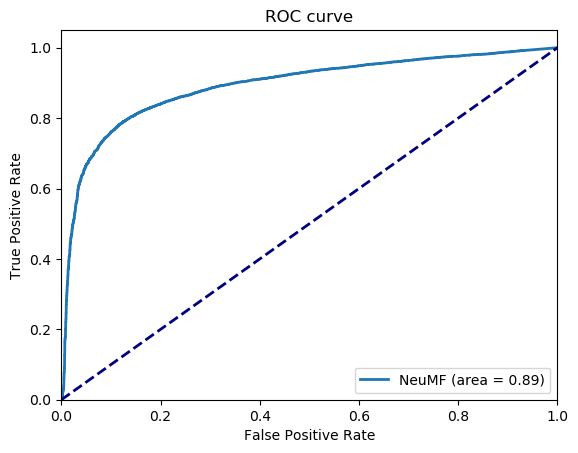

NeuMF
0.9541125584455046


<Figure size 640x480 with 0 Axes>

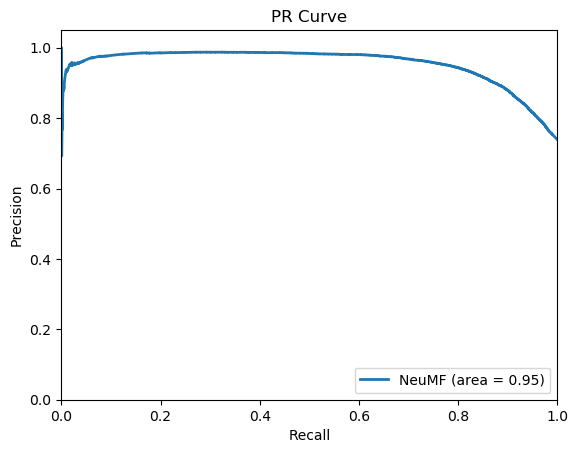

<Figure size 640x480 with 0 Axes>

In [9]:
#caluclate ROC and PR and plot

A = len(models)
scores_all = np.zeros((len(labels),A))    
for i in range(A):
    s = np.zeros(len(labels))
    #get users from data_test and predict score
    for j in range(data_test[0].shape[0]):
        user = data_test[0][j]
        item = data_test[1][j]
        s[j] = models[i].score(user, item) 
        
    s = s / max(s) #make it from 0-1
    scores_all[:,i]=s


np.save('scores.npy',scores_all)



plt.figure()
lw = 2
for i in range(A):    
    fpr, tpr, _ = roc_curve(labels, scores_all[:,i])
    roc_auc = auc(fpr, tpr)    
    
    
    print(models[i].name)
    print(roc_auc)
        
    plt.plot(fpr, tpr, 
             lw=lw, label= models[i].name + ' (area = %0.2f)' % roc_auc)

    
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
title= 'ROC curve'
plt.title(title)
plt.legend(loc="lower right")
plt.show()
plt.savefig(title + '.png')
    

plt.figure()
lw = 2
for i in range(A):    
    pr, rec, thr = precision_recall_curve(labels, scores_all[:,i] )
    avg_pr = average_precision_score(labels, scores_all[:,i])
    
    print(models[i].name)
    print(avg_pr)
    
    
    plt.plot(rec, pr, 
             lw=lw, label=models[i].name + ' (area = %0.2f)' % avg_pr)
    
title = 'PR curve'
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve')
plt.legend(loc="lower right")
plt.show()
plt.savefig(title + '.png')

AUXILIARY FUNTIONS FOR METRICS

In [10]:
def mrr_at_k(df,gt, k, method=0):
    
    matched_items = np.nonzero(np.in1d(df, gt))[0]

    if len(matched_items) == 0:
        return 0
    
    mrr = np.divide(1, (matched_items[0] + 1))  # +1 because indices start from 0 in python
    return mrr

In [11]:
def KLD(D1,D2):
    a = np.asarray(D1, dtype=np.float)
    b = np.asarray(D2, dtype=np.float)

    return np.sum(np.where(a != 0 , a * np.log((a +0.00001)/(b+0.00001)), 0))

def NDKL(df,p):
    Z = np.sum(1/(np.log2(np.arange(1,11)+1)))
    total=0

    for i in range(1,31): 
        value=df[:i].value_counts(normalize = True)
        value=value.to_dict()
        D1=[]
        for j in range(len(p)):
            if j in value.keys():
                D1.append(value[j])
            else:
                D1.append(0)
        total=total+(1/math.log2(i+1)) * KLD(D1,p)

    return (1/Z)*total

In [12]:
def dcg_at_k(r, k, method=0):
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0

def ndcg_at_k(df, k, method=0):
    r=list(df)
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    if not dcg_max:
        return 0.
    
    return dcg_at_k(r, k, method) / dcg_max


DETCONS ALGORITHM

In [13]:
def DetCons(data,p,kmax):

    rankedAttrList=[]
    rankedScoreList=[]
    counts={}
    for i in range(len(p)):
        counts[i]=0
    
    for k in range(1,kmax+1):
        belowMin = {ai for ai,v in counts.items() if v < math.floor(k*p[ai]) }
        belowMax = {ai for ai,v in counts.items() if v >= math.floor(k*p[ai]) and v <math.ceil(k*p[ai]) }
        s={}
        if len(belowMin)!=0:
            for i in belowMin:
                s[i]=data[(i,counts[i])]
            nextAtt= max(s,key=s.get)
                
        else: 
            s={}
            for i in belowMax:
                s[i]=math.ceil(i*p[i])/p[i]
                
            nextAtt= min(s,key=s.get)
                
        rankedAttrList.append(nextAtt)
        rankedScoreList.append(data[(nextAtt,counts[nextAtt])])
        counts[nextAtt]+=1
        
    return pd.DataFrame(list(zip(rankedAttrList, rankedScoreList)),columns =['ai', 'score'])

In [14]:
def DetCons1(data,p,kmax):

    rankedAttrList=[]
    rankedScoreList=[]
    counts={}
    for i in range(len(p)):
        counts[i]=0
    
    for k in range(1,kmax+1):
        belowMin = {ai for ai,v in counts.items() if v < math.floor(k*p[ai]) }
        belowMax = {ai for ai,v in counts.items() if v >= math.floor(k*p[ai]) and v <math.ceil(k*p[ai]) }
        s={}
        if len(belowMin)!=0:
            for i in belowMin:
                s[i]=data[(i,counts[i])]
            nextAtt= max(s,key=s.get)
                
        else: 
            s={}
            for i in belowMax:
                s[i]=math.ceil(i*p[i])/p[i]
                
            nextAtt= min(s,key=s.get)
                
        rankedAttrList.append(nextAtt)
        rankedScoreList.append(data[(nextAtt,counts[nextAtt])][0])
        counts[nextAtt]+=1
        
    return pd.DataFrame(list(zip(rankedAttrList, rankedScoreList)),columns =['ai', 'score'])

DETRELAX ALGORITHM

In [15]:
def DetRelax(data,p,kmax):

    rankedAttrList=[]
    rankedScoreList=[]
    counts={}
    for i in range(len(p)):
        counts[i]=0
    
    for k in range(1,kmax+1):
        belowMin = {ai for ai,v in counts.items() if v < math.floor(k*p[ai]) }
        belowMax = {ai for ai,v in counts.items() if v >= math.floor(k*p[ai]) and v <math.ceil(k*p[ai]) }
        s={}
        if len(belowMin)!=0:
            for i in belowMin:
                s[i]=data[(i,counts[i])]
            nextAtt= max(s,key=s.get)
                
        else: 
            ns={}
            for i in belowMax:
                ns[i]=math.ceil(math.ceil(i*p[i])/p[i])
            temp = min(ns.values()) 
            nextAttSet = [key for key in ns if ns[key] == temp] 
            for i in nextAttSet:
                s[i]=data[(i,counts[i])]
            
            nextAtt= max(s,key=s.get)
                
        rankedAttrList.append(nextAtt)
        rankedScoreList.append(data[(nextAtt,counts[nextAtt])])
        counts[nextAtt]+=1
        
    return pd.DataFrame(list(zip(rankedAttrList, rankedScoreList)),columns =['ai', 'score'])

In [16]:
def DetRelax1(data,p,kmax):

    rankedAttrList=[]
    rankedScoreList=[]
    counts={}
    for i in range(len(p)):
        counts[i]=0
    
    for k in range(1,kmax+1):
        belowMin = {ai for ai,v in counts.items() if v < math.floor(k*p[ai]) }
        belowMax = {ai for ai,v in counts.items() if v >= math.floor(k*p[ai]) and v <math.ceil(k*p[ai]) }
        s={}
        if len(belowMin)!=0:
            for i in belowMin:
                s[i]=data[(i,counts[i])]
            nextAtt= max(s,key=s.get)
                
        else: 
            ns={}
            for i in belowMax:
                ns[i]=math.ceil(math.ceil(i*p[i])/p[i])
            temp = min(ns.values()) 
            nextAttSet = [key for key in ns if ns[key] == temp] 
            for i in nextAttSet:
                s[i]=data[(i,counts[i])]
            
            nextAtt= max(s,key=s.get)
                
        rankedAttrList.append(nextAtt)
        rankedScoreList.append(data[(nextAtt,counts[nextAtt])][0])
        counts[nextAtt]+=1
        
    return pd.DataFrame(list(zip(rankedAttrList, rankedScoreList)),columns =['ai', 'score'])

DETGREEDY ALGORITHM

In [17]:
def DetGreedy(data,p,k_max):
    rankedAttList = [] 
    rankedScoreList = []
    counts={}
    for i in range(len(p)):
        counts[i]=0
    for k in range(1,k_max+1):
        belowMin = {ai for ai,v in counts.items() if v < math.floor(k*p[ai]) }
        #print("belowMinSet:",belowMin)
        belowMax = {ai for ai,v in counts.items() if v >= math.floor(k*p[ai]) and v <math.ceil(k*p[ai]) }
        #print("belowMaxSet:",belowMax)
        s={}
        if len(belowMin) != 0:
            for i in belowMin:
                s[i]=data[(i,counts[i])]
            nextAtt = max(s,key=s.get)
        else:
            for i in belowMax:
                s[i]=data[(i,counts[i])]
            nextAtt = max(s,key=s.get)
        #print("nextAtt:",nextAtt)   
        rankedAttList.append(nextAtt)
        #print("rankedAttList:",rankedAttList)
        rankedScoreList.append(data[(nextAtt,counts[nextAtt])])
        counts[nextAtt]+=1
        
    return pd.DataFrame(list(zip(rankedAttList, rankedScoreList)),columns =['ai', 'score'])

In [18]:
def DetGreedy1(data,p,k_max):
    rankedAttList = [] 
    rankedScoreList = []
    counts={}
    for i in range(len(p)):
        counts[i]=0
    for k in range(1,k_max+1):
        belowMin = {ai for ai,v in counts.items() if v < math.floor(k*p[ai]) }
        #print("belowMinSet:",belowMin)
        belowMax = {ai for ai,v in counts.items() if v >= math.floor(k*p[ai]) and v <math.ceil(k*p[ai]) }
        #print("belowMaxSet:",belowMax)
        s={}
        if len(belowMin) != 0:
            for i in belowMin:
                s[i]=data[(i,counts[i])]
            nextAtt = max(s,key=s.get)
        else:
            for i in belowMax:
                s[i]=data[(i,counts[i])]
            nextAtt = max(s,key=s.get)
        #print("nextAtt:",nextAtt)   
        rankedAttList.append(nextAtt)
        #print("rankedAttList:",rankedAttList)
        rankedScoreList.append(data[(nextAtt,counts[nextAtt])][0])
        counts[nextAtt]+=1
        
    return pd.DataFrame(list(zip(rankedAttList, rankedScoreList)),columns =['ai', 'score'])

READ USER FEATURES

In [19]:

user_info = pd.read_table(r"................users.csv", sep='\t',skiprows=1,
                        engine='python', names=['UserID','WindowID','Split','City','State','Country'
                                                ,'ZipCode','DegreeType','Major','GraduationDate','WorkHistoryCount',
                                                'TotalYearsExperience','CurrentlyEmployed','ManagedOthers','ManagedHowMany'])
user_info.head()

,UserID,WindowID,Split,City,State,Country,ZipCode,DegreeType,Major,GraduationDate,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,ManagedHowMany
0,47,1,Train,Paramount,CA,US,90723,High School,NaN,1999-06-01 00:00:00,3,10.0,Yes,No,0
1,72,1,Train,La Mesa,CA,US,91941,Master's,Anthropology,2011-01-01 00:00:00,10,8.0,Yes,No,0
2,80,1,Train,Williamstown,NJ,US,08094,High School,Not Applicable,1985-06-01 00:00:00,5,11.0,Yes,Yes,5
3,98,1,Train,Astoria,NY,US,11105,Master's,Journalism,2007-05-01 00:00:00,3,3.0,Yes,No,0
4,123,1,Train,Baton Rouge,LA,US,70808,Bachelor's,Agricultural Business,2011-05-01 00:00:00,1,9.0,Yes,No,0


AUXILIARY FUNTIONS FOR UNARY ENCODING APPLICATION

In [20]:
domain=[0.0,1.0,2.0,3.0,4.0]

In [21]:
p = .9999999999999999
q = .0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001

In [22]:
def unary_epsilon(p, q):
    return np.log((p*(1-q)) / ((1-p)*q))

unary_epsilon(.65, .35)

1.2380784168124472

In [23]:
def encode(response):
    return [1 if d == response else 0 for d in domain]

def perturb(encoded_response):
    return [perturb_bit(b) for b in encoded_response]

def perturb_bit(bit):
    
    sample = np.random.random()

    if bit == 1:
        if sample <= p:
            return 1
        else:
            return 0
    elif bit == 0:
        if sample <= q:
            return 1
        else: 
            return 0

USE UNARY ENCODING ON USER FEATURE==State AND PREPARE DATA FOR EXPERIMENT

In [24]:
score_cvdr=scores_all[:]
test_data = ratio_split.test_set.uir_tuple
iid = ratio_split.global_iid_map
uid = ratio_split.global_uid_map

user_info=user_info.to_numpy() 

job_list=[]
unique_jobs=[]
ratings=[]
ratings2=[]
ratings3=[]
cat4=0
cat5=0
info2=[]
responses=[]

for k in range (test_data[1].shape[0]):
    #print(test_data[1].shape[0]-k)
    cat=0
    cat3=0
    for n in range (len(user_info)):
        if (str(user_info[n][0]) in iid) and (iid[str(user_info[n][0])] == test_data[1][k]) :
            cat=user_info[n][4]
            if cat in {"CA","AZ","WA","ID","NV","AK","UT","OR"}:
                cat3=0.0
            elif cat in {"TX","MT","NM","CO","MN","AR","KS","IA","MO","LA","OK","WY","NE","ND","SD","HI"}:
                cat3=1.0  
            elif cat in {"NY","NJ","SC","MD","RI","PA","CT","VA","WV","ME","DE","NC","NH","MA","VT"}:
                cat3=2.0
            elif cat in {"FL","IL","GA","OH","IN","AL","KY","TN","MS","WI","MI"}:
                cat3=3.0
            else:
                cat3=4.0
    
    
    cat5=perturb(encode(cat3))
    responses.append(cat5)
    #print(cat5)
    cat4 = int("".join(str(x) for x in cat5), 2)
    #print(cat4)

    info2.append(cat3)
    
    
    job = test_data[0][k] 
    user = test_data[1][k]

    rate = score_cvdr[k]
    
    
    job_list.append(job)

    if test_data[2][k]==1: 
        ratings2.append((user,job,rate,cat4,cat3,user))
    else:
        ratings2.append((user,job,rate,cat4,cat3,0))

info_user2 = pd.DataFrame(list(zip(info2)),columns =['cat'])  
#print(info_user)   
    
for job in job_list:
    if job not in unique_jobs:
        unique_jobs.append(job)

CALCULATE PROPABILITY DISTRIBUTION FOR UNARY ENCONDING APPLICATION

In [25]:
n = 4

def get_prob(n: int, k: int) -> float:
    ## probability of getting a specific d-dimensional output that has n '1's.

    prob1 = p     * q**(k-1) * (1-q)**(n-k) 
    prob2 = (1-p) * q**k     * (1-q)**(n-k-1)
    
    prob = (1/n) * ( k * prob1 + (n-k) * prob2 )
    
    return prob


total_prob = 0
for k in range(0, n+1):
    prob = get_prob(n, k)
    
    combs = math.factorial(n) / (math.factorial(k) * math.factorial(n-k))
    
    print(k,'=',combs,prob)

    total_prob += combs * prob


print(total_prob)


0 = 1.0 1.1102230246251565e-16
1 = 4.0 0.24999999999999997
2 = 6.0 4.999999999999999e-305
3 = 4.0 0.0
4 = 1.0 0.0
1.0


In [26]:
# Create the array
array_size = 2**n
array_props = np.zeros(array_size)

# Populate the array with values from get_prob function
for i in range(array_size):
    binary_rep = bin(i)[2:].zfill(n)  # Get binary representation of index
    k = binary_rep.count('1')  # Count the number of 1s
    array_props[i] = get_prob(n, k)

print(array_props)
print(sum(array_props))

[1.11022302e-016 2.50000000e-001 2.50000000e-001 5.00000000e-305
 2.50000000e-001 5.00000000e-305 5.00000000e-305 0.00000000e+000
 2.50000000e-001 5.00000000e-305 5.00000000e-305 0.00000000e+000
 5.00000000e-305 0.00000000e+000 0.00000000e+000 0.00000000e+000]
1.0


RUN THE EXPERIMENT FOR UNARY ENCONDING

In [27]:
class experiment:
    """ 
    This is a class to prepare data required to run the algorithms.
    It takes in the following variables as user inputs :-
    'max_a' = Maximum cardinality of protected class for which we want to generate data
    'datapoints' = The number of synthetic Scores to generate for different 'ai' values
    """
    
    def __init__(self,max_a,rep):
        self.max_a=max_a
        self.rep=rep
        self.datapoints=30
        
    
    def setup(self):
        P = {}
        self.data={}
        a=self.max_a
        P[f'a={a}']=self.get_tasks(a)
        for i in P[f'a={a}']:
            for j in range(self.rep): 
                #print(unique_jobs[j])
                self.data[(f'a={a}',i,j)] = self.gen_data(unique_jobs[j],a)
        return P
    
    
    def get_tasks(self,a):
        T={}
        T[i]=self.get_distribution(a)
        
        return T

    def get_distribution(self,a):
        d=[]
        for i in range(a):
            d.append(1/a)
        d_norm = [float(i)/sum(d) for i in d]
        return d_norm

    def gen_data(self,job_index,a):
        scores={}
        random.seed(1)
        for i in range(a):
            scoresgen=[]   
            for m in range(len(ratings2)):
                    #print(ratings[m][0])
                if ratings2[m][1]==job_index and ratings2[m][3]==i:
                    if ratings2[m][2] < 0:
                        l = list(ratings2[m])
                        l[2] = 0 
                        ratings2[m]=tuple(l)
                    score=[ratings2[m][2],ratings2[m][4],ratings2[m][5]]
                    scoresgen.append(score)
            while len(scoresgen)< self.datapoints :
                x=random.randint(0, 4)
                scoresgen.append([0.0,x,0.0])              
            scoresgen.sort(reverse=True)
            for j in range(self.datapoints):
                    scores[(i,j)]=scoresgen[j]
        #print(scores)
        return scores
    
    def get_value(self,a,i,j):
        return self.data[(f'a={a}',i,j)]

In [28]:
%%time
demo = experiment(16,len(unique_jobs))
P = demo.setup()
print(P)
print(f'Data prepared successfully!!')

{'a=16': {15: [0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625]}}
Data prepared successfully!!
Wall time: 27min 36s


In [29]:
class re_ranking:
    def __init__(self,a,demo):
        self.a=a
        self.demo=demo

        self.ndcg_vanilla=[]
        self.ndcg_DetGreedy=[]
        self.ndcg_DetCons=[]
        self.ndcg_DetRelax=[]
       
        self.mrr_vanilla=[]
        self.mrr_DetGreedy=[]
        self.mrr_DetCons=[]
        self.mrr_DetRelax=[]
        
        self.ndkl_vanilla=[]
        self.ndkl_DetGreedy=[]
        self.ndkl_DetCons=[]
        self.ndkl_DetRelax=[]

        
    def output(self,a,i,j,demo):
        data = demo.get_value(a,i,j)
        df = pd.Series(data).rename_axis(['ai', 'index']).reset_index(name='score')
        df.sort_values(by=['score'], inplace=True,ascending=False)
        df = df.reset_index(drop=True)
        
        Algo6=DetGreedy1(data,array_props,30)
        Algo7=DetCons1(data,array_props,30)
        Algo8=DetRelax1(data,array_props,30)
        users6=DetGreedy(data,array_props,30)
        users7=DetCons(data,array_props,30)
        users8=DetRelax(data,array_props,30)
        #print(Algo6)
        #print(users6)

        return df,Algo6, Algo7, Algo8, users6, users7, users8
        

    def compute_metrics(self):

        print(f'\n Computing Metrics Starting!!')
        for j in range(1000):
                #print(i)
                #print(j)
                df, Algo6, Algo7, Algo8, users6, users7, users8= self.output(self.a,i,j,demo)            
                
                df2=[]
                df3=[]
                df13=[]
                for k in range(30):
                    df2.append(df['score'][k][0])
                    df3.append(df['score'][k][1])
                    df13.append(df['score'][k][2])
                   
                df9 = pd.DataFrame(list(zip(df2)),columns =['score'])
                df4 = pd.DataFrame(list(zip(df3)),columns =['ai'])
                df41 = pd.DataFrame(list(zip(df13)),columns =['ai'])
                
                if ndcg_at_k(df9['score'],30)==0.0:
                    self.ndcg_vanilla.append(1.0)
                else:
                    self.ndcg_vanilla.append(ndcg_at_k(df9['score'],30))
                                             
                if ndcg_at_k(Algo6['score'],30) == 0.0:   
                    self.ndcg_DetGreedy.append(1.0)                        
                else:
                    self.ndcg_DetGreedy.append(ndcg_at_k(Algo6['score'],30))
                                             
                if ndcg_at_k(Algo7['score'],30)==0.0:
                    self.ndcg_DetCons.append(1.0)                        
                else:                            
                    self.ndcg_DetCons.append(ndcg_at_k(Algo7['score'],30))
                                             
                if ndcg_at_k(Algo8['score'],30)==0.0:
                    self.ndcg_DetRelax.append(1.0)                        
                else:                           
                    self.ndcg_DetRelax.append(ndcg_at_k(Algo8['score'],30))
                
                user6=[]
                user7=[]
                user8=[]
                user61=[]
                user71=[]
                user81=[]
            
                for l in range(30):
                    user6.append(users6['score'][l][1])
                    user7.append(users7['score'][l][1])
                    user8.append(users8['score'][l][1])
                    user61.append(users6['score'][l][2])
                    user71.append(users7['score'][l][2])
                    user81.append(users8['score'][l][2])
                
                df5 = pd.DataFrame(list(zip(user6)),columns =['ai'])
                df6 = pd.DataFrame(list(zip(user7)),columns =['ai'])
                df7 = pd.DataFrame(list(zip(user8)),columns =['ai'])
                df51 = pd.DataFrame(list(zip(user61)),columns =['ai'])
                df61 = pd.DataFrame(list(zip(user71)),columns =['ai'])
                df71 = pd.DataFrame(list(zip(user81)),columns =['ai'])
                #print(df41)
                #print(user61)
                
                self.mrr_vanilla.append(mrr_at_k(df4['ai'],df41['ai'],30))
                self.mrr_DetGreedy.append(mrr_at_k(df5['ai'],df51['ai'],30))
                self.mrr_DetCons.append(mrr_at_k(df6['ai'],df61['ai'],30)) 
                self.mrr_DetRelax.append(mrr_at_k(df7['ai'],df71['ai'],30))
                
                self.ndkl_vanilla.append(NDKL(df4['ai'],[0.2,0.2,0.2,0.2,0.2]))
                self.ndkl_DetGreedy.append(NDKL(df5['ai'],[0.2,0.2,0.2,0.2,0.2]))
                self.ndkl_DetCons.append(NDKL(df6['ai'],[0.2,0.2,0.2,0.2,0.2]))
                self.ndkl_DetRelax.append(NDKL(df7['ai'],[0.2,0.2,0.2,0.2,0.2]))

In [30]:
ndcg_plot={}
ndcg_plot["vanilla"]=[]
ndcg_plot["DetGreedy"]=[]
ndcg_plot["DetCons"]=[]
ndcg_plot["DetRelax"]=[]

mrr_plot={}
mrr_plot["vanilla"]=[]
mrr_plot["DetGreedy"]=[]
mrr_plot["DetCons"]=[]
mrr_plot["DetRelax"]=[]

ndkl_plot={}
ndkl_plot["vanilla"]=[]
ndkl_plot["DetGreedy"]=[]
ndkl_plot["DetCons"]=[]
ndkl_plot["DetRelax"]=[]

    
rank = re_ranking(16,demo)
rank.compute_metrics()
print(f' \n Computing Metrics...Finished Successfully !!')
ndcg_plot["vanilla"].append(np.mean(rank.ndcg_vanilla))
ndcg_plot["DetGreedy"].append(np.mean(rank.ndcg_DetGreedy))
ndcg_plot["DetCons"].append(np.mean(rank.ndcg_DetCons))
ndcg_plot["DetRelax"].append(np.mean(rank.ndcg_DetRelax))

mrr_plot["vanilla"].append(np.mean(rank.mrr_vanilla))
mrr_plot["DetGreedy"].append(np.mean(rank.mrr_DetGreedy))
mrr_plot["DetCons"].append(np.mean(rank.mrr_DetCons))
mrr_plot["DetRelax"].append(np.mean(rank.mrr_DetRelax))


ndkl_plot["vanilla"].append(np.mean(rank.ndkl_vanilla))
ndkl_plot["DetGreedy"].append(np.mean(rank.ndkl_DetGreedy))
ndkl_plot["DetCons"].append(np.mean(rank.ndkl_DetCons))
ndkl_plot["DetRelax"].append(np.mean(rank.ndkl_DetRelax))



 Computing Metrics Starting!!
 
 Computing Metrics...Finished Successfully !!


ndcg
1.0
0.9166111365821835
0.5925655500210453
0.8208718088859925
ndkl
2.6343723020958603
2.5771880571933847
2.7090420562728976
2.6210086188731223
mrr
0.005
0.005
0.0015
0.0025


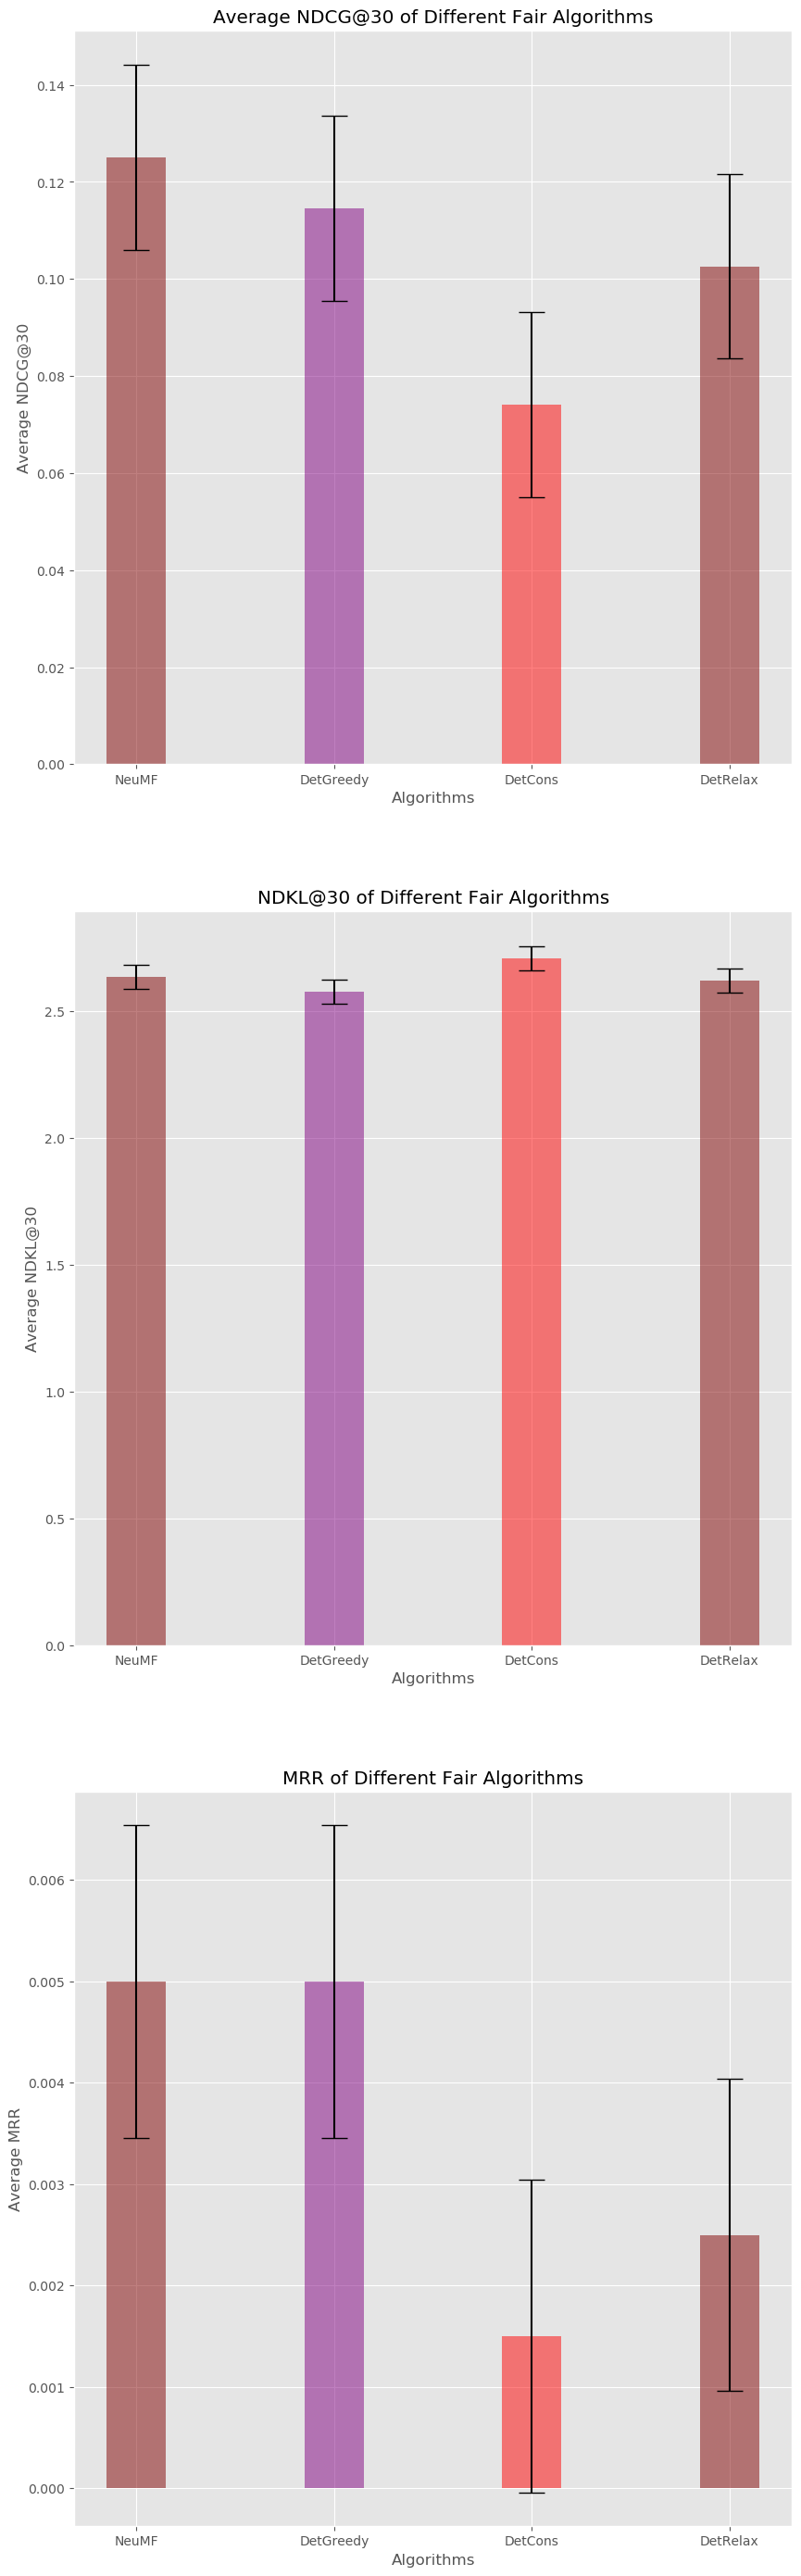

In [34]:
plt.style.use('ggplot')
fig, (ax1, ax2, ax3) = plt.subplots(3, 1,figsize=(10,35))
 

print("ndcg")
print(ndcg_plot["vanilla"][0])
print(ndcg_plot["DetGreedy"][0])
print(ndcg_plot["DetCons"][0])
print(ndcg_plot["DetRelax"][0])


# creating the dataset
data = {'NeuMF':0.1250, 'DetGreedy':ndcg_plot["DetGreedy"][0]*0.1250,
        'DetCons':ndcg_plot["DetCons"][0]*0.1250, 'DetRelax':ndcg_plot["DetRelax"][0]*0.1250}

keys = list(data.keys())
values = list(data.values())
error= np.std(values)
# creating the bar plot

ax1.bar(keys, values, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10, color ={'maroon','purple','red'}, width = 0.3)
 
ax1.set_xlabel("Algorithms")
ax1.set_ylabel("Average NDCG@30")
ax1.set_title("Average NDCG@30 of Different Fair Algorithms")


print("ndkl")
print(ndkl_plot["vanilla"][0])
print(ndkl_plot["DetGreedy"][0])
print(ndkl_plot["DetCons"][0])
print(ndkl_plot["DetRelax"][0])


# creating the dataset
data = {'NeuMF':ndkl_plot["vanilla"][0], 'DetGreedy':ndkl_plot["DetGreedy"][0],
        'DetCons':ndkl_plot["DetCons"][0],'DetRelax':ndkl_plot["DetRelax"][0]}


keys = list(data.keys())
values = list(data.values())
error= np.std(values) 

# creating the bar plot
ax2.bar(keys, values, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10, color ={'maroon','purple','red'}, width = 0.3)

ax2.set_xlabel("Algorithms")
ax2.set_ylabel("Average NDKL@30")
ax2.set_title("NDKL@30 of Different Fair Algorithms")



print("mrr")
print(mrr_plot["vanilla"][0])
print(mrr_plot["DetGreedy"][0])
print(mrr_plot["DetCons"][0])
print(mrr_plot["DetRelax"][0])


# creating the dataset
data = {'NeuMF':mrr_plot["vanilla"][0], 'DetGreedy':mrr_plot["DetGreedy"][0],
        'DetCons':mrr_plot["DetCons"][0],'DetRelax':mrr_plot["DetRelax"][0]}


keys = list(data.keys())
values = list(data.values())
error= np.std(values) 

# creating the bar plot
ax3.bar(keys, values, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10, color ={'maroon','purple','red'}, width = 0.3)

ax3.set_xlabel("Algorithms")
ax3.set_ylabel("Average MRR")
ax3.set_title("MRR of Different Fair Algorithms")


plt.show()

AULIARY FUNCTIONS FOR Generalized Randomized Response APPLICATION

In [35]:
p = .95
q = .05
n_groups=5
epsilon = unary_epsilon(p, q)
print(epsilon)

rr_p = np.exp(epsilon) / (np.exp(epsilon) + n_groups - 1)
print(rr_p)
rr_q = 1 / (np.exp(epsilon) + n_groups - 1)
rr_epsilon = np.log(rr_p/rr_q)

print(rr_epsilon)


5.88887795833288
0.9890410958904109
5.88887795833288


In [36]:
def rand_resp(epsilon,group,n_groups):
    
    p = np.exp(epsilon) / (np.exp(epsilon) + n_groups - 1)
    q = 1 / (np.exp(epsilon) + n_groups - 1)
    probs = np.array([p if  i==group else q for i in range(n_groups)])
    from numpy.random import choice
    rr_group = choice(
  n_groups, p=probs)
    return rr_group

USE GRR ON USER FEATURE==State AND PREPARE DATA FOR EXPERIMENT

In [37]:
score_cvdr=scores_all[:]
test_data = ratio_split.test_set.uir_tuple
iid = ratio_split.global_iid_map
uid = ratio_split.global_uid_map

#user_info=user_info.to_numpy() 

job_list=[]
unique_jobs=[]
ratings=[]
ratings2=[]
ratings3=[]
cat4=0
cat5=0
info2=[]
responses=[]

for k in range (test_data[1].shape[0]):
    #print(test_data[1].shape[0]-k)
    cat=0
    cat3=0
    for n in range (len(user_info)):
        if (str(user_info[n][0]) in iid) and (iid[str(user_info[n][0])] == test_data[1][k]) :
            cat=user_info[n][4]
            if cat in {"CA","AZ","WA","ID","NV","AK","UT","OR"}:
                cat3=0.0
            elif cat in {"TX","MT","NM","CO","MN","AR","KS","IA","MO","LA","OK","WY","NE","ND","SD","HI"}:
                cat3=1.0  
            elif cat in {"NY","NJ","SC","MD","RI","PA","CT","VA","WV","ME","DE","NC","NH","MA","VT"}:
                cat3=2.0
            elif cat in {"FL","IL","GA","OH","IN","AL","KY","TN","MS","WI","MI"}:
                cat3=3.0
            else:
                cat3=4.0
    
    
    cat4=rand_resp(epsilon,cat3,5)
    
    mat=[[1,0,0,0,0],[0,1,0,0,0],[0,0,1,0,0],[0,0,0,1,0],[0,0,0,0,1]]
    cat5 = mat[int(cat4)]
    
    responses.append(cat5)
    #print(cat5)
    #print(cat4)
 
    info2.append(cat3)

    
    job = test_data[0][k] 
    user = test_data[1][k]

    rate = score_cvdr[k]
    
    
    job_list.append(job)

    if test_data[2][k]==1: 
        ratings2.append((user,job,rate,cat4,cat3,user))
    else:
        ratings2.append((user,job,rate,cat4,cat3,0))

info_user2 = pd.DataFrame(list(zip(info2)),columns =['cat'])  
#print(info_user)   
    
for job in job_list:
    if job not in unique_jobs:
        unique_jobs.append(job)

PROPABILITY DISTRIBUTION FOR APPLICATION OF RERANKING ALGORITHMS

In [38]:
array_props=[0.2,0.2,0.2,0.2,0.2]

RUN THE EXPERIMENT FOR GRR

In [39]:
class experiment:
    """ 
    This is a class for preparation of data required to run the algorithms.
    It takes in the following variables as user inputs :-
    'max_a' = Maximum cardinality of protected class for which we want to generate synthetic data
    'datapoints' = The number of synthetic Scores to generate for different 'ai' values
    """
    
    def __init__(self,max_a,rep):
        self.max_a=max_a
        self.rep=rep
        self.datapoints=30
    
        
    
    def setup(self):
        P = {}
        self.data={}
        a=self.max_a
        P[f'a={a}']=self.get_tasks(a)
        for i in P[f'a={a}']:
            for j in range(self.rep): 
                #print(unique_jobs[j])
                self.data[(f'a={a}',i,j)] = self.gen_data(unique_jobs[j],a)
        return P
    
    
    def get_tasks(self,a):
        T={}
        T[i]=self.get_distribution(a)
        
        return T

    def get_distribution(self,a):
        d=[]
        for i in range(a):
            d.append(1/a)
        d_norm = [float(i)/sum(d) for i in d]
        return d_norm

    def gen_data(self,job_index,a):
        scores={}
        random.seed(1)
        for i in range(a):
            scoresgen=[]   
            for m in range(len(ratings2)):
                    #print(ratings[m][0])
                if ratings2[m][1]==job_index and ratings2[m][3]==i:
                    if ratings2[m][2] < 0:
                        l = list(ratings2[m])
                        l[2] = 0 
                        ratings2[m]=tuple(l)
                    score=[ratings2[m][2],ratings2[m][4],ratings2[m][5]]
                    scoresgen.append(score)
            while len(scoresgen)< self.datapoints :
                x=random.randint(0, 4)
                scoresgen.append([0.0,x,0.0])              
            scoresgen.sort(reverse=True)
            for j in range(self.datapoints):
                    scores[(i,j)]=scoresgen[j]
        #print(scores)
        return scores
    
    def get_value(self,a,i,j):
        return self.data[(f'a={a}',i,j)]

In [40]:
%%time
demo = experiment(5,len(unique_jobs))
P = demo.setup()
print(P)
print(f'Data prepared successfully!!')

{'a=5': {15: [0.2, 0.2, 0.2, 0.2, 0.2]}}
Data prepared successfully!!
Wall time: 7min 26s


In [41]:
class re_ranking:
    def __init__(self,a,demo):
        self.a=a
        self.demo=demo

        self.ndcg_vanilla=[]
        self.ndcg_DetGreedy=[]
        self.ndcg_DetCons=[]
        self.ndcg_DetRelax=[]
       
        self.mrr_vanilla=[]
        self.mrr_DetGreedy=[]
        self.mrr_DetCons=[]
        self.mrr_DetRelax=[]

        self.ndkl_vanilla=[]
        self.ndkl_DetGreedy=[]
        self.ndkl_DetCons=[]
        self.ndkl_DetRelax=[]

    def output(self,a,i,j,demo):
        data = demo.get_value(a,i,j)
        df = pd.Series(data).rename_axis(['ai', 'index']).reset_index(name='score')
        df.sort_values(by=['score'], inplace=True,ascending=False)
        df = df.reset_index(drop=True)
        
        Algo6=DetGreedy1(data,array_props,30)
        Algo7=DetCons1(data,array_props,30)
        Algo8=DetRelax1(data,array_props,30)
        users6=DetGreedy(data,array_props,30)
        users7=DetCons(data,array_props,30)
        users8=DetRelax(data,array_props,30)
        #print(Algo6)
        #print(users6)
        
        return df,Algo6, Algo7, Algo8, users6, users7, users8
        

    def compute_metrics(self):

        print(f'\n Computing Metrics Starting!!')
        for j in range(1000):#range(demo.rep):
                
                df, Algo6, Algo7, Algo8, users6, users7, users8= self.output(self.a,i,j,demo) 
                            
                df2=[]
                df3=[]
                df13=[]
                for k in range(30):
                    df2.append(df['score'][k][0])
                    df3.append(df['score'][k][1])
                    df13.append(df['score'][k][2])
                   
                df9 = pd.DataFrame(list(zip(df2)),columns =['score'])
                df4 = pd.DataFrame(list(zip(df3)),columns =['ai'])
                df41 = pd.DataFrame(list(zip(df13)),columns =['ai'])
                
                
                if ndcg_at_k(df9['score'],30)==0.0:
                    self.ndcg_vanilla.append(1.0)
                else:
                    self.ndcg_vanilla.append(ndcg_at_k(df9['score'],30))
                                             
                if ndcg_at_k(Algo6['score'],30) == 0.0:   
                    self.ndcg_DetGreedy.append(1.0)                        
                else:
                    self.ndcg_DetGreedy.append(ndcg_at_k(Algo6['score'],30))
                                             
                if ndcg_at_k(Algo7['score'],30)==0.0:
                    self.ndcg_DetCons.append(1.0)                        
                else:                            
                    self.ndcg_DetCons.append(ndcg_at_k(Algo7['score'],30))
                                             
                if ndcg_at_k(Algo8['score'],30)==0.0:
                    self.ndcg_DetRelax.append(1.0)                        
                else:                           
                    self.ndcg_DetRelax.append(ndcg_at_k(Algo8['score'],30))
                
                user6=[]
                user7=[]
                user8=[]
                user61=[]
                user71=[]
                user81=[]
            
                for l in range(30):
                    user6.append(users6['score'][l][1])
                    user7.append(users7['score'][l][1])
                    user8.append(users8['score'][l][1])
                    user61.append(users6['score'][l][2])
                    user71.append(users7['score'][l][2])
                    user81.append(users8['score'][l][2])
                
                df5 = pd.DataFrame(list(zip(user6)),columns =['ai'])
                df6 = pd.DataFrame(list(zip(user7)),columns =['ai'])
                df7 = pd.DataFrame(list(zip(user8)),columns =['ai'])
                df51 = pd.DataFrame(list(zip(user61)),columns =['ai'])
                df61 = pd.DataFrame(list(zip(user71)),columns =['ai'])
                df71 = pd.DataFrame(list(zip(user81)),columns =['ai'])
                
                
                self.mrr_vanilla.append(mrr_at_k(df4['ai'],df41['ai'],30))
                self.mrr_DetGreedy.append(mrr_at_k(df5['ai'],df51['ai'],30))
                self.mrr_DetCons.append(mrr_at_k(df6['ai'],df61['ai'],30)) 
                self.mrr_DetRelax.append(mrr_at_k(df7['ai'],df71['ai'],30))
                
                self.ndkl_vanilla.append(NDKL(df4['ai'],[0.2,0.2,0.2,0.2,0.2]))
                self.ndkl_DetGreedy.append(NDKL(df5['ai'],[0.2,0.2,0.2,0.2,0.2]))
                self.ndkl_DetCons.append(NDKL(df6['ai'],[0.2,0.2,0.2,0.2,0.2]))
                self.ndkl_DetRelax.append(NDKL(df7['ai'],[0.2,0.2,0.2,0.2,0.2]))
                

In [42]:
ndcg_plot={}
ndcg_plot["vanilla"]=[]
ndcg_plot["DetGreedy"]=[]
ndcg_plot["DetCons"]=[]
ndcg_plot["DetRelax"]=[]

mrr_plot={}
mrr_plot["vanilla"]=[]
mrr_plot["DetGreedy"]=[]
mrr_plot["DetCons"]=[]
mrr_plot["DetRelax"]=[]

ndkl_plot={}
ndkl_plot["vanilla"]=[]
ndkl_plot["DetGreedy"]=[]
ndkl_plot["DetCons"]=[]
ndkl_plot["DetRelax"]=[]

    
rank = re_ranking(5,demo)
rank.compute_metrics()
print(f' \n Computing Metrics...Finished Successfully !!')
ndcg_plot["vanilla"].append(np.mean(rank.ndcg_vanilla))
ndcg_plot["DetGreedy"].append(np.mean(rank.ndcg_DetGreedy))
ndcg_plot["DetCons"].append(np.mean(rank.ndcg_DetCons))
ndcg_plot["DetRelax"].append(np.mean(rank.ndcg_DetRelax))


mrr_plot["vanilla"].append(np.mean(rank.mrr_vanilla))
mrr_plot["DetGreedy"].append(np.mean(rank.mrr_DetGreedy))
mrr_plot["DetCons"].append(np.mean(rank.mrr_DetCons))
mrr_plot["DetRelax"].append(np.mean(rank.mrr_DetRelax))
    
ndkl_plot["vanilla"].append(np.mean(rank.ndkl_vanilla))
ndkl_plot["DetGreedy"].append(np.mean(rank.ndkl_DetGreedy))
ndkl_plot["DetCons"].append(np.mean(rank.ndkl_DetCons))
ndkl_plot["DetRelax"].append(np.mean(rank.ndkl_DetRelax))


 Computing Metrics Starting!!
 
 Computing Metrics...Finished Successfully !!


ndcg
1.0
0.9087657849965262
0.6538356414032942
0.8985735987376126
ndkl
2.5461742798794433
2.4549992692935287
2.512645459728228
2.4224669355669386
mrr
0.13645
0.13683333333333333
0.1386666666666667
0.1395


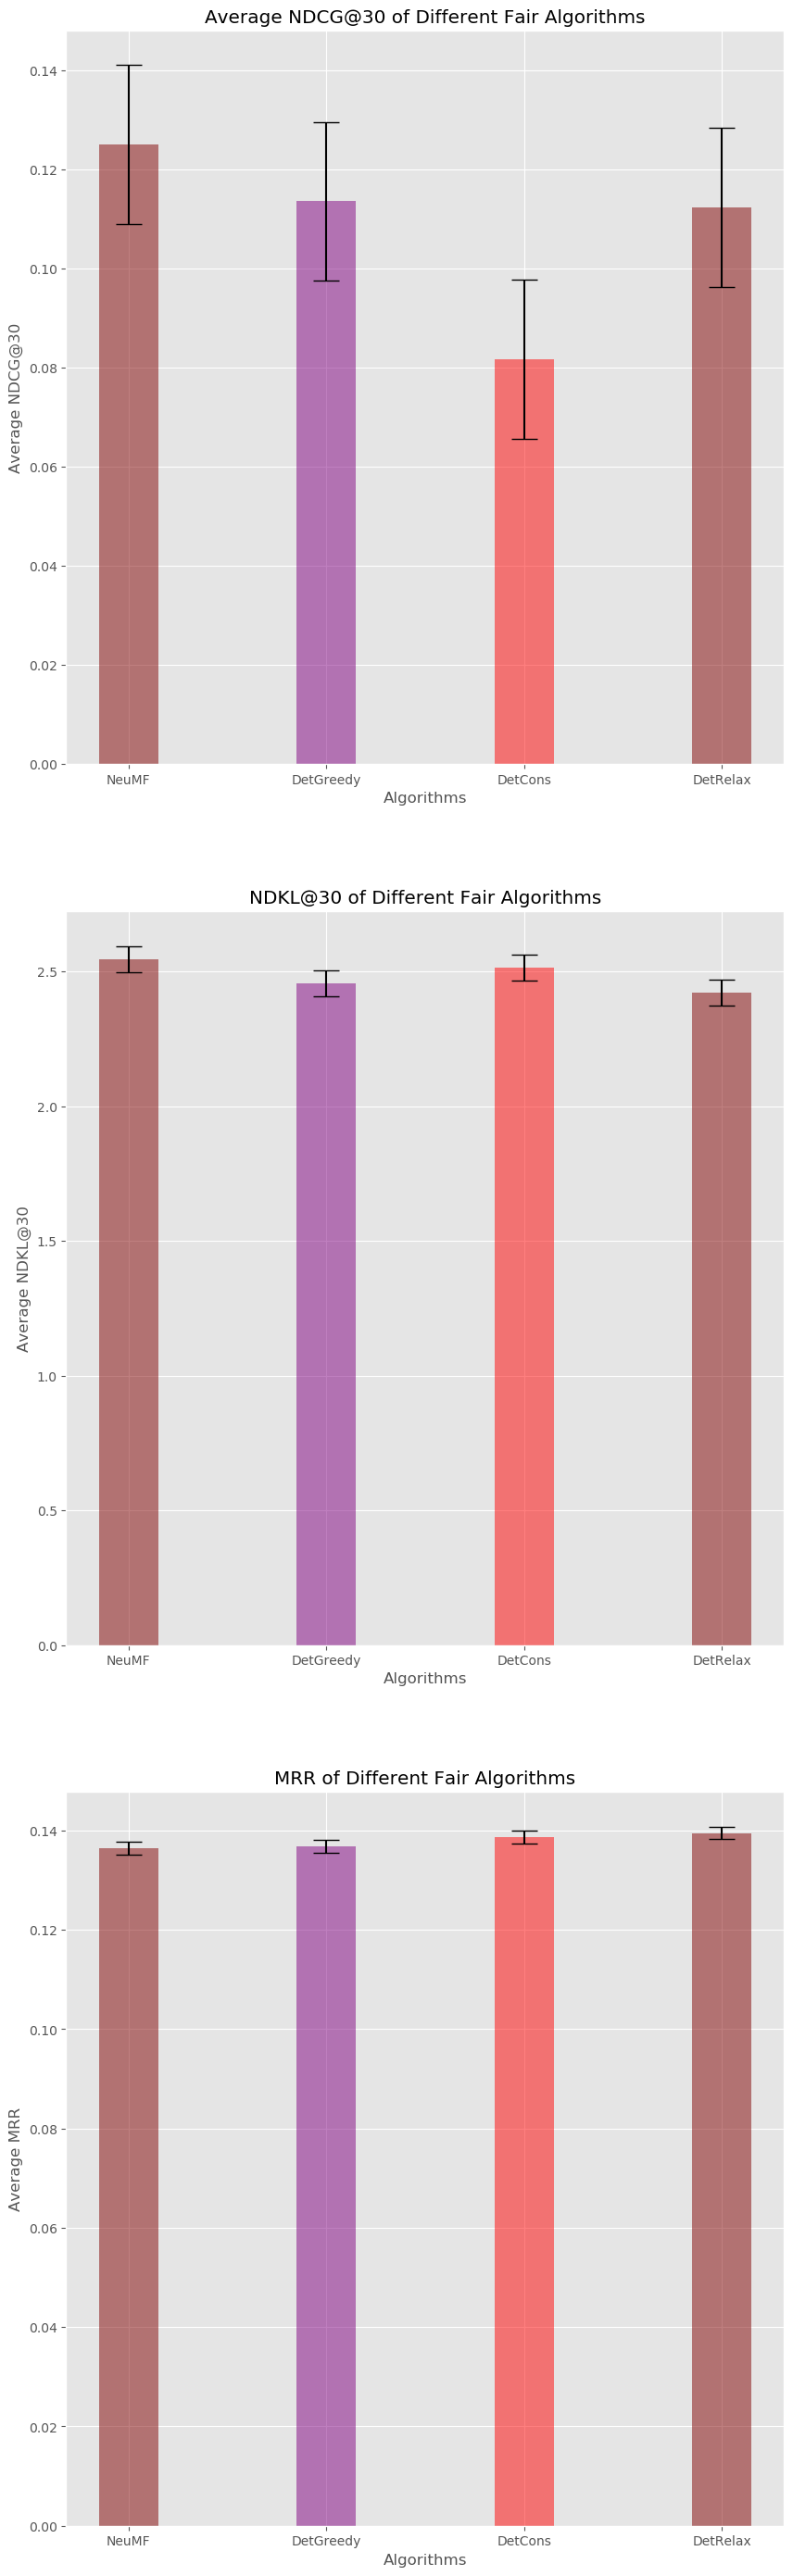

In [43]:
plt.style.use('ggplot')
fig, (ax1, ax2, ax3) = plt.subplots(3, 1,figsize=(10,35))
 

print("ndcg")
print(ndcg_plot["vanilla"][0])
print(ndcg_plot["DetGreedy"][0])
print(ndcg_plot["DetCons"][0])
print(ndcg_plot["DetRelax"][0])


# creating the dataset
data = {'NeuMF':0.1250, 'DetGreedy':ndcg_plot["DetGreedy"][0]*0.1250,
        'DetCons':ndcg_plot["DetCons"][0]*0.1250, 'DetRelax':ndcg_plot["DetRelax"][0]*0.1250}

keys = list(data.keys())
values = list(data.values())
error= np.std(values)
# creating the bar plot

ax1.bar(keys, values, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10, color ={'maroon','purple','red'}, width = 0.3)
 
ax1.set_xlabel("Algorithms")
ax1.set_ylabel("Average NDCG@30")
ax1.set_title("Average NDCG@30 of Different Fair Algorithms")


print("ndkl")
print(ndkl_plot["vanilla"][0])
print(ndkl_plot["DetGreedy"][0])
print(ndkl_plot["DetCons"][0])
print(ndkl_plot["DetRelax"][0])


# creating the dataset
data = {'NeuMF':ndkl_plot["vanilla"][0], 'DetGreedy':ndkl_plot["DetGreedy"][0],
        'DetCons':ndkl_plot["DetCons"][0],'DetRelax':ndkl_plot["DetRelax"][0]}


keys = list(data.keys())
values = list(data.values())
error= np.std(values) 

# creating the bar plot
ax2.bar(keys, values, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10, color ={'maroon','purple','red'}, width = 0.3)

ax2.set_xlabel("Algorithms")
ax2.set_ylabel("Average NDKL@30")
ax2.set_title("NDKL@30 of Different Fair Algorithms")



print("mrr")
print(mrr_plot["vanilla"][0])
print(mrr_plot["DetGreedy"][0])
print(mrr_plot["DetCons"][0])
print(mrr_plot["DetRelax"][0])


# creating the dataset
data = {'NeuMF':mrr_plot["vanilla"][0], 'DetGreedy':mrr_plot["DetGreedy"][0],
        'DetCons':mrr_plot["DetCons"][0],'DetRelax':mrr_plot["DetRelax"][0]}


keys = list(data.keys())
values = list(data.values())
error= np.std(values) 

# creating the bar plot
ax3.bar(keys, values, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10, color ={'maroon','purple','red'}, width = 0.3)

ax3.set_xlabel("Algorithms")
ax3.set_ylabel("Average MRR")
ax3.set_title("MRR of Different Fair Algorithms")


plt.show()